In [101]:
import os
import glob
import pyperclip
import pandas as pd
import numpy as np
import random
import string
from datetime import datetime

from obspy import UTCDateTime
import matplotlib.pyplot as plt

# Set the working directory
data_path = "../data/eq_data/all_data"

# Phasenet picks to PyRocko (snuffler) format marker file:

## 1(a). Check the phasenet picks
- phase_score (0-1.0) defines how good is the quality of the pick
- put cut-off if needed

Number of picks with score < 0.5: 900 out of 2895


Text(0, 0.5, 'Number of picks')

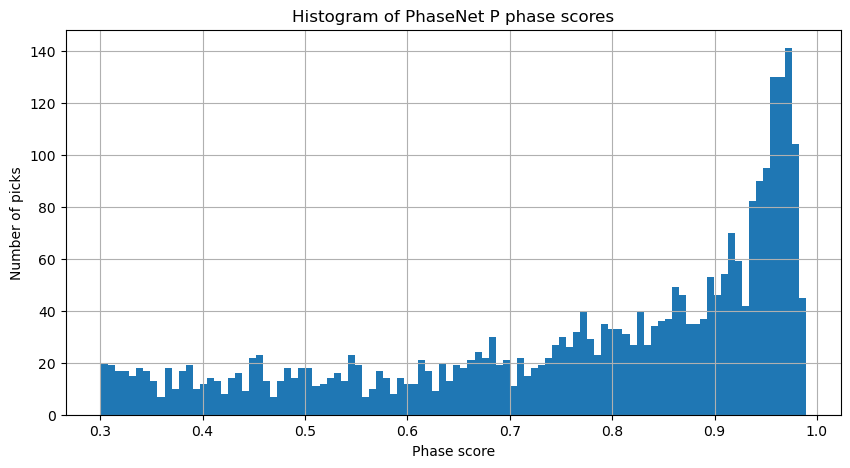

In [102]:
phasenet_picks_all = pd.read_csv(
    f"{data_path}/phasenet_files/phasenet_phasepick_datetime.csv",
    parse_dates=["phase_time"], 
)
df = phasenet_picks_all.copy()

# keep only P phases
df = df[df.phase_type == "P"]

df.sort_values(by="phase_score", ascending=True, inplace=True)

# number of rows (picks) with < 0.5 score
print(f"Number of picks with score < 0.5: {len(df[df.phase_score < 0.7])} out of {len(df)}")

# histogram of phase scores
df.phase_score.hist(bins=100, figsize=(10, 5))
plt.title("Histogram of PhaseNet P phase scores")
plt.xlabel("Phase score")
plt.ylabel("Number of picks")

In [103]:
phasenet_picks_file = f"{data_path}/phasenet_files/phasenet_phasepick_datetime.csv"

# make a list of all mseed files in datapath without .mseed extension
event_id_list = [os.path.basename(fname).split(".")[0] for fname in glob.glob(f"{data_path}/*.mseed")]
# event_id_list = ["nc40221138"] # for testing

# call the function to make pyrocko files
done_status = True
if done_status==False:
    phasenet_picks_to_pyrocko(
        event_id_list=event_id_list, 
        phasenet_picks_file=phasenet_picks_file, 
        data_path=data_path,
    )

## 2. Check status how many events are done.
- phases picked before manually and by phasenet (polarity assigned and corrected manually)
- Get the event ID for the next event to check the phasepicks and add polarity

In [104]:
# make a data folder to store all data in the same folder
data_path = "../data/eq_data/all_data"
os.makedirs(data_path, exist_ok=True)

# Make a list of .mseed files into a csv file to input into PhaseNet command line
mseed_list = [os.path.basename(fname) for fname in glob.glob(f"{data_path}/*.mseed")]

# done_list with files that have been picked already using PyRocko
pyrocko_list = [os.path.basename(fname) for fname in glob.glob(f"{data_path}/*_PyRocko_picks.txt")]
pn2pr_list = [os.path.basename(fname) for fname in glob.glob(f"{data_path}/*_marker_PN2PR_checked.txt")]

# make a dataframe with the mseed_list
pick_state_df = pd.DataFrame(mseed_list, columns=["event"])
pick_state_df.event = pick_state_df.event.str.replace(".mseed", "")

# add the event name to the done_list
# 1. manually picked events
done_list = [f.split("_")[0] for f in pyrocko_list]
# 2. Phasenet picked events, manual polarity assignment and corrected picks [{event_id}_marker_PN2PR_checked.txt]
done_list.extend([f.split("_")[0] for f in pn2pr_list])

# Add 'done_picking' column to the dataframe if the event has been picked (True) or not (False)
pick_state_df["done_picking"] = pick_state_df.event.isin(done_list)

# sort by true and false and reset index
pick_state_df = pick_state_df.sort_values(by="done_picking", ascending=False).reset_index(drop=True)

# random string generator
def random_string(length):
    """
    PyRocko binds different picks to the same event using a random string.
    So, we need to generate a random string for each event.
    input: length of the random string
    output: random string
    """
    # generate a random string but with seed so that it is reproducible
    random.seed(10) # seed 10 means the same random string will be generated each time
    random_string = ''.join(random.choices(string.ascii_letters + string.digits, k=27)) + "="
    return random_string

# make a list of random strings
random_strings = [random_string(30) for i in range(len(pick_state_df))]

# add the random strings to the dataframe
pick_state_df["random_string"] = random_strings

# Merge all the manual picked marker files into one master marker file
- Follow the following format from `snuffler`:
    - `phase: 2015-04-16 06:38:16.2762  0 SX.NEUB..BHZ    4342fb5oj726   2015-04-16   06:38:08.8350 P        None False`
### Plan:
1. get files that has old picks
2. read the old picks
3. add `event details` [event id, event origin time] to these old pick files
4. merge all the edited picks files for PYROCKO manual picked files
5. append the PHASENET picks files to this master file
    - add event details to them
6. use this master file to open all mseed files with all marker files [and all event files if needed]

N.B. In this case I already made pyrocko format marker file from Phasenet file. So I used that. Next time I will make it directly from phasenet csv file.


In [105]:
# Read the old marker files following format:
# # Snuffler Markers File Version 0.2
# phase: 2008-04-30 03:03:11.8071  0 XQ.ME30.01.BHZ  None           None         None         P          -1 False

# read the catalog file with all the events
eq_df = pd.read_csv(
    '../data/above_slab_eq_0.2_grid.csv', 
    parse_dates=["time"],
)

# make a new dataframe with the same columns
master_marker_df = pd.DataFrame(
    columns=["phase", "date", "time", "0", "station", "event_id", "edate", "etime", "phase_type", "polarity", "False"]
    )


# loop through the done_picking dataframe
for i, row in pick_state_df.iterrows():
    event_id = row.event
    identifier = row.random_string

    if row.done_picking == True:
        old_marker_file = f"{data_path}/{event_id}_PyRocko_picks.txt"

        # if _PyRocko_picks.txt file does not exist, it means I alreadt checked it in pyrocko
        # so I will use the _marker_PN2PR_checked.txt file
        if not os.path.exists(old_marker_file):
            old_marker_file = f"{data_path}/{event_id}_marker_PN2PR_checked.txt"
    else:
        old_marker_file = f"{data_path}/{event_id}_marker_PN2PR.txt"

    # print(f"Reading {old_marker_file}")

    old_marker_df = pd.read_csv(
        old_marker_file,
        skiprows=1,
        # use whitespace as the delimiter
        sep="\s+",
        names=["phase", "date", "time", "0", "station", "event_id", "edate", "etime", "phase_type", "polarity", "False"],
        dtype={"polarity": "str"},

    )


    # insert the event_id, event origin time [from the catalog]
    old_marker_df.event_id = event_id
    old_marker_df["identifier"] = identifier # old markers don't have this column, so create it
    old_marker_df.edate = pd.to_datetime(eq_df[eq_df.id == event_id].time.iloc[0]).strftime("%Y-%m-%d")
    old_marker_df.etime = pd.to_datetime(eq_df[eq_df.id == event_id].time.iloc[0]).strftime("%H:%M:%S.%f")

    # add the old_marker_df to the master_marker_df
    master_marker_df = pd.concat([master_marker_df, old_marker_df], ignore_index=True)


master_marker_df.polarity = master_marker_df.polarity.replace(np.nan, "None")

# sort it by date and time
master_marker_df.sort_values(by=["date", "time"], inplace=True)

master_marker_df.reset_index(drop=True, inplace=True)
master_marker_df.head()

,phase,date,time,0,station,event_id,edate,etime,phase_type,polarity,False,identifier
0,phase:,2008-02-24,13:00:24.9899,0,XQ.ME30.01.BHZ,nc71100926,2008-02-24,13:00:20.860000,P,1,False,JAJmYZOjGup79c1LxrPCQPiV88M=
1,phase:,2008-02-24,13:00:26.4265,0,BK.JCC..HHZ,nc71100926,2008-02-24,13:00:20.860000,P,-1,False,JAJmYZOjGup79c1LxrPCQPiV88M=
2,phase:,2008-02-24,13:00:26.5135,0,XQ.ME31.01.BHZ,nc71100926,2008-02-24,13:00:20.860000,P,-1,False,JAJmYZOjGup79c1LxrPCQPiV88M=
3,phase:,2008-02-24,13:00:28.4170,0,XQ.ME32.01.BHZ,nc71100926,2008-02-24,13:00:20.860000,P,-1,False,JAJmYZOjGup79c1LxrPCQPiV88M=
4,phase:,2008-02-24,13:00:30.2303,0,XQ.ME33.01.BHZ,nc71100926,2008-02-24,13:00:20.860000,P,-1,False,JAJmYZOjGup79c1LxrPCQPiV88M=


In [106]:
outfile = f"{data_path}/00_master_marker_ASSOCIATED.txt"

# "event: 2015-04-16 06:38:08.8350  0 4342fb5oj726   51.4177088165 12.1322880252  29344.72658 3.22029 None  gfz2015hkiy None"
# group the master_marker_df by event_id and write to file, but
# add one line of event information before the markers for each event

with open(outfile, "w") as file:
    # # Snuffler Markers File Version 0.2 add as the first line
    file.write(f"# Snuffler Markers File Version 0.2| Generated from Phasenet picks csv by - Md Ariful Islam @ IUB {datetime.now().date()}\n")
    for event_id, group in master_marker_df.groupby("event_id"):
        # get the event info from the catalog
        event_info = eq_df[eq_df.id == event_id].iloc[0]

        # write the event line, one line for each event at the top
        event_line = f"event: {group.edate.iloc[0]} {group.etime.iloc[0]}  0 {group.identifier.iloc[0]}"
        event_line += f" {event_info.latitude} {event_info.longitude} {event_info.depth} {event_info.mag} None  {event_id} None\n"
        file.write(event_line)

        # write the markers
        for i, row in group.iterrows():
            file.write(f"phase: {row.date} {row.time[0:13]}  0 {(row.station).ljust(15)}    {row.identifier}   {row.edate}   {row.etime[0:13]} {row.phase_type}{8*' '}{str(row.polarity).rjust(4)} False\n")
        


# Make event file for pyrocko
-

In [107]:
"""
name = 1912271248
time = 2019-12-27 20:00:29.676000
latitude = -4.51783
longitude = -104.95885
depth = 4449.0
-------------------------------------------- 
"""
# use os.path.relpath(path-to-file,[opt:current or desired directory]) 
# to get the relative path from the current directory

# make a master event file.txt to store all the events
with open(f"{data_path}/00_master_event_file_PyRocko.txt", "w") as file:
    file.write("")

# loop through the need_picking dataframe
for i, event_id in enumerate(pick_state_df.event):
    # get the event info from the catalog
    event_info = eq_df[eq_df.id == event_id].iloc[0]

    # write to the master event file
    with open(f"{data_path}/00_master_event_file_PyRocko.txt", "a") as file:
        file.write(f"name = {event_info.id}\n")
        file.write(f"time = {pd.to_datetime(event_info.time).strftime('%Y-%m-%d %H:%M:%S.%f')}\n")
        file.write(f"latitude = {event_info.latitude}\n")
        file.write(f"longitude = {event_info.longitude}\n")
        file.write(f"depth = {event_info.depth}\n")
        file.write(f"--------------------------------------------\n") 

## 2. Make terminal command code for running snuffler with markers and copy it to clipboard

In [2]:
import pyperclip
marker_file = f"00_master_marker_ASSOCIATED_v2.txt"
cmd = f"snuffler *.mseed --stationxml=00_station_inventory_master.xml --markers={marker_file}" #--event=00_master_event_file_PyRocko.txt
pyperclip.copy(cmd)
print(f"Command is copied to clipboard: {cmd}")

Command is copied to clipboard: snuffler *.mseed --stationxml=00_station_inventory_master.xml --markers=00_master_marker_ASSOCIATED_v2.txt


In [18]:
import pandas as pd
df = pd.read_csv("../data/eq_data/all_data/00_master_marker_ASSOCIATED_v2.txt", sep="\s+",
                header=None,
                skiprows=1,
                
                )
# df[df["event:"] == "event:"].shape[0]
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,event:,2008-02-24,13:00:20.86000,0,LLqmax1RQiKKhEDmqkrrbLqCYsQ=,40.9003333,-123.7216667,4.19,3.28,NaN,nc71100926,NaN
1,phase:,2008-02-24,13:00:24.98990,0,XQ.ME30.01.BHZ,LLqmax1RQiKKhEDmqkrrbLqCYsQ=,2008-02-24,13:00:20.86000,P,1.0,False,NaN
2,phase:,2008-02-24,13:00:26.42650,0,BK.JCC..HHZ,LLqmax1RQiKKhEDmqkrrbLqCYsQ=,2008-02-24,13:00:20.86000,P,-1.0,False,NaN
3,phase:,2008-02-24,13:00:26.51350,0,XQ.ME31.01.BHZ,LLqmax1RQiKKhEDmqkrrbLqCYsQ=,2008-02-24,13:00:20.86000,P,-1.0,False,NaN
4,phase:,2008-02-24,13:00:28.41700,0,XQ.ME32.01.BHZ,LLqmax1RQiKKhEDmqkrrbLqCYsQ=,2008-02-24,13:00:20.86000,P,-1.0,False,NaN


# has wrong picked file:

nc51207076